In [1]:
import xarray as xr 

# ds = xr.open_dataset('/teamspace/studios/this_studio/b1ed4f6500ab47792814630e7136eb47.nc')
ds = xr.open_dataset('/Users/adamprzychodni/Documents/Repos/ml-drought-forecasting/ml-modeling-pipeline/data/01_raw/e16fe5f664d5290665a25e5afad51ce9.nc')

In [2]:
ds 

<xarray.Dataset> Size: 2GB
Dimensions:    (date: 96, latitude: 721, longitude: 1440)
Coordinates:
    number     int64 8B ...
  * date       (date) int64 768B 20150101 20150201 ... 20221101 20221201
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver     (date) <U4 2kB ...
Data variables:
    t2m        (date, latitude, longitude) float32 399MB ...
    sst        (date, latitude, longitude) float32 399MB ...
    tp         (date, latitude, longitude) float32 399MB ...
    pev        (date, latitude, longitude) float32 399MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-10T08:42 GRIB to CDM+CF via cfgrib-0.9.1...

In [3]:
import numpy as np
import xarray as xr

# Step 1: Define target grid with 0.5° resolution
target_lat = np.arange(-90, 90.1, 1)   # From -90 to 90 degrees inclusive
target_lon = np.arange(0, 360, 1)      # From 0 to 359.5 degrees inclusive

# Step 2: Create target grid Dataset (optional, for reference)
target_grid = xr.Dataset(
    {
        "latitude": (["latitude"], target_lat),
        "longitude": (["longitude"], target_lon),
    }
)

# Step 3: Ensure latitude is ascending
if ds.latitude[0] > ds.latitude[-1]:
    ds = ds.sortby("latitude")

# Step 4: Perform interpolation
ds_regridded = ds.interp(latitude=target_lat, longitude=target_lon, method="linear")


In [4]:
ds = ds_regridded

In [5]:
# ds = ds.sel(longitude=slice(0, 10))
ds = ds.sel(latitude=slice(-30, 30))

In [6]:
import pandas as pd

# Convert 'date' coordinate to datetime if not already
ds['date'] = pd.to_datetime(ds['date'].astype(str), format='%Y%m%d')

/usr/local/Caskroom/miniconda/base/envs/kedro-environment/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:2594: RuntimeWarning: overflow encountered in exp
  Cx = (1+np.exp(-x))**(-c)


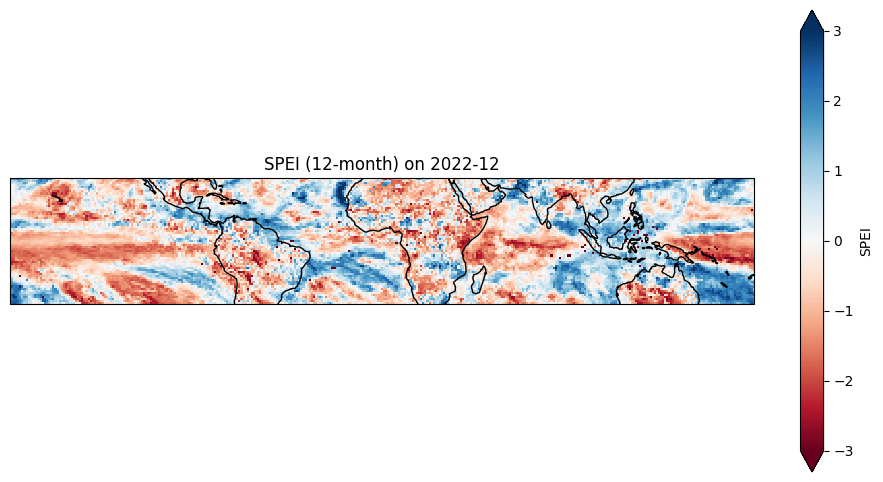

In [7]:
import xarray as xr
import numpy as np
import pandas as pd
from scipy.stats import genlogistic, norm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Assuming your dataset is loaded into ds

# Convert units from meters to millimeters
ds['tp_mm'] = ds['tp'] * 1000  # Convert to mm
ds['pev_mm'] = ds['pev'] * 1000  # Convert to mm

# Calculate water balance D = P - PET
ds['D'] = ds['tp_mm'] - ds['pev_mm']

# Set the time scale for SPEI calculation
scale = 12  # 12 months

# Aggregate over the time scale
D_rolling = ds['D'].rolling(date=scale, center=False).sum().dropna('date')

# Define the function to calculate SPEI
def calculate_spei(series):
    # Remove NaN values
    series = series[~np.isnan(series)]
    
    if len(series) < 3:
        # Not enough data to fit the distribution
        return np.full(series.shape, np.nan)
    
    # Fit the log-logistic distribution
    try:
        c, loc, scale_param = genlogistic.fit(series)
    except Exception as e:
        # If fitting fails, return NaNs
        return np.full(series.shape, np.nan)
    
    # Calculate cumulative probabilities
    probs = genlogistic.cdf(series, c, loc=loc, scale=scale_param)
    
    # Ensure probabilities are within valid range
    probs = np.clip(probs, 1e-6, 1 - 1e-6)
    
    # Convert cumulative probabilities to SPEI values (standard normal variates)
    spei_values = norm.ppf(probs)
    
    return spei_values

# Ensure the data is chunked appropriately for dask parallelization
D_rolling_chunked = D_rolling.chunk({'latitude': 10, 'longitude': 10})

# Apply the function across all grid points
spei = xr.apply_ufunc(
    calculate_spei,
    D_rolling_chunked,
    input_core_dims=[['date']],
    output_core_dims=[['date']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float],
    keep_attrs=True
)

# Compute the results
spei = spei.compute()

# Assign coordinates and attributes
spei = spei.assign_coords({
    'latitude': ds.latitude,
    'longitude': ds.longitude,
    'date': D_rolling.date
})

spei.name = f'SPEI_{scale}'
spei.attrs['long_name'] = f'Standardized Precipitation Evapotranspiration Index ({scale}-month scale)'
spei.attrs['units'] = 'Standard Deviations'

# Visualize the SPEI for a specific date
plot_date = spei.date.values[-1]

plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
spei.sel(date=plot_date).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='RdBu',
    vmin=-3,
    vmax=3,
    cbar_kwargs={'label': 'SPEI'}
)
ax.coastlines()
ax.set_title(f'SPEI ({scale}-month) on {pd.to_datetime(str(plot_date)).strftime("%Y-%m")}')
plt.show()


In [8]:
spei 

<xarray.DataArray 'SPEI_12' (latitude: 61, longitude: 360, date: 85)> Size: 15MB
array([[[-5.14704535e-01, -7.56827585e-01, -8.56795817e-01, ...,
         -7.23956618e-01, -7.17093387e-01, -3.45191184e-01],
        [-2.46493140e-01, -4.78549668e-01, -6.70555663e-01, ...,
         -1.05627489e+00, -9.80921238e-01, -6.13591175e-01],
        [ 5.68507570e-01,  4.84078254e-01,  2.71290054e-01, ...,
         -1.33718954e+00, -1.21570542e+00, -1.01706538e+00],
        ...,
        [-6.63384810e-01, -1.08223511e+00, -1.16652558e+00, ...,
         -1.41720198e-01,  4.53492213e-02,  2.03040556e-01],
        [-1.92789240e-01, -6.06091030e-01, -6.09957971e-01, ...,
         -2.98288872e-01, -1.26221268e-01,  1.30740873e-01],
        [-5.13480613e-01, -7.72826369e-01, -7.30144026e-01, ...,
         -6.39459664e-01, -4.32360376e-01, -4.45664790e-02]],

       [[ 1.27395188e-01, -1.22658612e-02, -2.91789213e-01, ...,
         -1.49706450e+00, -1.35716801e+00, -9.56702343e-01],
        [ 3.27125021e-01,  2.16955652e-01, -3.90046140e-02, ...,
         -1.34566022e+00, -1.28463914e+00, -7.65542863e-01],
        [ 1.21986848e+00,  1.13708472e+00,  9.14977596e-01, ...,
         -9.32605566e-01, -7.69707032e-01, -6.52021865e-01],
...
        [-2.85606748e-01, -2.88886403e-01, -2.91336317e-01, ...,
          9.15613536e-01,  7.96259764e-01,  1.05246237e+00],
        [ 9.51453936e-01,  9.46425507e-01,  9.27988529e-01, ...,
          8.31304620e-01,  8.03209886e-01,  8.71190584e-01],
        [ 8.05453156e-01,  6.12783500e-01,  5.22688071e-01, ...,
         -4.56881812e-01, -8.67309739e-01, -9.96244614e-01]],

       [[ 7.91474431e-01,  6.94695649e-01,  5.09565469e-01, ...,
         -5.22775532e-01, -1.06257491e+00, -1.27189087e+00],
        [ 6.74374493e-01,  4.94792782e-01,  5.65580135e-02, ...,
         -9.46616412e-01, -2.13668500e+00, -2.27504081e+00],
        [-2.10083516e-01, -4.94838534e-01, -9.15712549e-01, ...,
         -4.26966171e-01, -2.31397800e+00, -2.39308494e+00],
        ...,
        [ 2.77392245e-01,  2.42355406e-01, -6.50214671e-01, ...,
          1.48914383e+00,  3.07246239e-03,  1.21861252e-01],
        [-5.09702681e-02, -3.78172952e-02, -7.10427199e-01, ...,
          2.15302289e-02, -1.26445338e+00, -1.27400875e+00],
        [ 7.66566172e-01,  7.59103869e-01,  2.27965250e-01, ...,
         -3.08664849e-04, -2.39488653e-01, -3.59773102e-01]]])
Coordinates:
    number     int64 8B 0
    expver     (date) <U4 1kB '0001' '0001' '0001' ... '0001' '0001' '0001'
  * date       (date) datetime64[ns] 680B 2015-12-01 2016-01-01 ... 2022-12-01
  * latitude   (latitude) float64 488B -30.0 -29.0 -28.0 ... 28.0 29.0 30.0
  * longitude  (longitude) int64 3kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
Attributes:
    long_name:  Standardized Precipitation Evapotranspiration Index (12-month...
    units:      Standard Deviations

In [79]:
import numpy as np
import xarray as xr

# Assuming your dataset is called ds
# Example dataset variables: t2m, sst, tp, pev

# 1. Extract relevant variables
targets = ['pev']
data_arrays = [ds[var] for var in targets]

# 2. Flatten latitude and longitude into a single node dimension
# Combine the latitude and longitude as one "node" dimension
data_arrays_flattened = [da.stack(node=('latitude', 'longitude')) for da in data_arrays]

# 3. Convert each variable's DataArray to a numpy array and add a new channel dimension
# (so we have the shape (time, nodes, channels))
target = np.stack([da.to_numpy() for da in data_arrays_flattened], axis=-1)


In [10]:
target

array([[[ 7.82310963e-08],
        [ 7.82310963e-08],
        [ 7.82310963e-08],
        ...,
        [-5.74748963e-04],
        [ 1.27032399e-06],
        [ 3.16649675e-07]],

       [[-2.60770321e-08],
        [-2.60770321e-08],
        [-2.60770321e-08],
        ...,
        [-8.59286636e-04],
        [-7.41332769e-07],
        [-7.41332769e-07]],

       [[ 3.72529030e-09],
        [ 3.72529030e-09],
        [ 3.72529030e-09],
        ...,
        [-1.29174814e-03],
        [-1.42678618e-06],
        [-1.18836761e-06]],

       ...,

       [[ 1.49011612e-08],
        [ 1.49011612e-08],
        [ 1.49011612e-08],
        ...,
        [-1.41094625e-03],
        [-1.89244747e-06],
        [-1.65402889e-06]],

       [[-9.31322575e-08],
        [-9.31322575e-08],
        [-9.31322575e-08],
        ...,
        [-9.12521034e-04],
        [-1.04680657e-06],
        [-1.04680657e-06]],

       [[-1.49011612e-08],
        [-1.49011612e-08],
        [-1.49011612e-08],
        ...,
        

In [11]:
# Save as .npy file
np.save('ml-drought-forecasting/ml-modeling-pipeline/data/05_model_input/target.npy', target)

In [12]:
# 1. Create a boolean mask where valid values are True and invalid (NaN) values are False
mask = ~np.isnan(target)

In [13]:
mask

array([[[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]],

       [[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]],

       [[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]],

       ...,

       [[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]],

       [[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]],

       [[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]]])

In [14]:
# Save as .npy file
np.save('ml-drought-forecasting/ml-modeling-pipeline/data/05_model_input/mask.npy', mask)

In [15]:
import numpy as np
import xarray as xr

# Assuming your dataset is called ds
# Example dataset variables: t2m, sst, tp, pev

# 1. Extract relevant variables
variables = ['t2m', 'sst', 'tp']
data_arrays = [ds[var] for var in variables]

# 2. Flatten latitude and longitude into a single node dimension
# Combine the latitude and longitude as one "node" dimension
data_arrays_flattened = [da.stack(node=('latitude', 'longitude')) for da in data_arrays]

# 3. Convert each variable's DataArray to a numpy array and add a new channel dimension
# (so we have the shape (time, nodes, channels))
covariates = np.stack([da.to_numpy() for da in data_arrays_flattened], axis=-1)


In [16]:
covariates

array([[[2.93111450e+02, 2.94215332e+02, 5.56945801e-04],
        [2.92982544e+02, 2.94182129e+02, 6.48498535e-04],
        [2.92791138e+02, 2.93830566e+02, 5.30242920e-04],
        ...,
        [2.82250122e+02,            nan, 6.67572021e-06],
        [2.81875122e+02,            nan, 1.71661377e-05],
        [2.81355591e+02,            nan, 1.52587891e-05]],

       [[2.94114044e+02, 2.95475098e+02, 3.67164612e-04],
        [2.93910919e+02, 2.95384277e+02, 3.45230103e-04],
        [2.93698029e+02, 2.95097168e+02, 3.65257263e-04],
        ...,
        [2.87533966e+02,            nan, 1.14440918e-05],
        [2.86303497e+02,            nan, 2.47955322e-05],
        [2.85502716e+02,            nan, 4.29153442e-05]],

       [[2.93340271e+02, 2.94870117e+02, 8.90731812e-04],
        [2.93225037e+02, 2.94642578e+02, 7.41004944e-04],
        [2.93129333e+02, 2.94491211e+02, 7.39097595e-04],
        ...,
        [2.92641052e+02,            nan, 6.48498535e-05],
        [2.91719177e+02,     

In [17]:
import numpy as np

# Zakładając, że 'covariates' jest Twoim array'em numpy
covariates = np.nan_to_num(covariates, nan=0.0)

In [18]:
covariates


array([[[2.93111450e+02, 2.94215332e+02, 5.56945801e-04],
        [2.92982544e+02, 2.94182129e+02, 6.48498535e-04],
        [2.92791138e+02, 2.93830566e+02, 5.30242920e-04],
        ...,
        [2.82250122e+02, 0.00000000e+00, 6.67572021e-06],
        [2.81875122e+02, 0.00000000e+00, 1.71661377e-05],
        [2.81355591e+02, 0.00000000e+00, 1.52587891e-05]],

       [[2.94114044e+02, 2.95475098e+02, 3.67164612e-04],
        [2.93910919e+02, 2.95384277e+02, 3.45230103e-04],
        [2.93698029e+02, 2.95097168e+02, 3.65257263e-04],
        ...,
        [2.87533966e+02, 0.00000000e+00, 1.14440918e-05],
        [2.86303497e+02, 0.00000000e+00, 2.47955322e-05],
        [2.85502716e+02, 0.00000000e+00, 4.29153442e-05]],

       [[2.93340271e+02, 2.94870117e+02, 8.90731812e-04],
        [2.93225037e+02, 2.94642578e+02, 7.41004944e-04],
        [2.93129333e+02, 2.94491211e+02, 7.39097595e-04],
        ...,
        [2.92641052e+02, 0.00000000e+00, 6.48498535e-05],
        [2.91719177e+02, 0.00

In [19]:
# Save as .npy file
np.save('ml-drought-forecasting/ml-modeling-pipeline/data/05_model_input/covariates.npy', covariates)

In [20]:
import pandas as pd
import os

def generate_and_save_metadata(df: pd.DataFrame, lat_col: str = 'lat', lon_col: str = 'lon', save_directory: str = None) -> pd.DataFrame:
    """
    Generates metadata from a given DataFrame by identifying unique latitude and longitude
    combinations and assigning a unique node ID to each combination. The metadata is then
    saved to a specified Parquet file.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - lat_col (str): The name of the column containing latitude data.
    - lon_col (str): The name of the column containing longitude data.
    - save_directory (str, optional): The directory where the metadata file will be saved. If None, 
                                      the file will be saved in the current working directory.

    Returns:
    - pd.DataFrame: A DataFrame containing the metadata with latitude, longitude, and 'node_id' as columns.
    """
    # Ensure the DataFrame contains necessary columns
    if lat_col not in df.columns or lon_col not in df.columns:
        raise ValueError(f"DataFrame must contain '{lat_col}' and '{lon_col}' columns.")

    # Create a unique node ID for each unique latitude-longitude combination
    unique_lat_lon = df[[lat_col, lon_col]].drop_duplicates().reset_index(drop=True)
    unique_lat_lon['node_id'] = unique_lat_lon.index

    # Create the metadata DataFrame
    metadata = unique_lat_lon.set_index('node_id')

    # Handle save directory and save metadata to Parquet file
    if save_directory:
        os.makedirs(save_directory, exist_ok=True)  # Create directory if it doesn't exist
        file_path = os.path.join(save_directory, "metadata.parquet")
    else:
        file_path = "metadata.parquet"  # Save in the current working directory

    metadata.to_parquet(file_path)
    print(f"Metadata file saved at: {file_path}")

    return metadata


In [21]:
import pandas as pd
import os

# Assume you've already stacked your data arrays as 'data_arrays_flattened'
# We'll use one of the flattened DataArrays to extract the node information
da_flattened = data_arrays_flattened[0]  # Using the first variable for example

# Get the MultiIndex from the 'node' dimension
node_index = da_flattened.indexes['node']

# Extract latitude and longitude from the MultiIndex
latitudes = node_index.get_level_values('latitude').values
longitudes = node_index.get_level_values('longitude').values

# Create a DataFrame with 'lat' and 'lon' columns
df = pd.DataFrame({
    'lat': latitudes,
    'lon': longitudes
})

# Now use your 'generate_and_save_metadata' function
metadata = generate_and_save_metadata(
    df, 
    lat_col='lat', 
    lon_col='lon', 
    save_directory='ml-drought-forecasting/ml-modeling-pipeline/data/05_model_input/'
)


Metadata file saved at: ml-drought-forecasting/ml-modeling-pipeline/data/05_model_input/metadata.parquet


<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.Tensor size changed, may indicate binary incompatibility. Expected 64 from C header, got 80 from PyObject


In [22]:
# metadata

In [23]:
import pandas as pd
metadata = pd.read_parquet("ml-drought-forecasting/ml-modeling-pipeline/data/05_model_input/metadata.parquet")

In [24]:
metadata

,lat,lon
node_id,,
0,-30.0,0
1,-30.0,1
2,-30.0,2
3,-30.0,3
4,-30.0,4
...,...,...
21955,30.0,355
21956,30.0,356
21957,30.0,357


In [25]:
# Converting the DataFrame to a numpy ndarray
metadata_array = metadata.to_numpy()

In [26]:
metadata_array

array([[-30.,   0.],
       [-30.,   1.],
       [-30.,   2.],
       ...,
       [ 30., 357.],
       [ 30., 358.],
       [ 30., 359.]])

In [27]:
# Save as .npy file
np.save('ml-drought-forecasting/ml-modeling-pipeline/data/05_model_input/metadata.npy', metadata_array)

In [28]:
from tsl.ops.similarities import geographical_distance
# Calculate geographical distances with coordinates converted to radians.
dist = geographical_distance(metadata_array, to_rad=True)

In [29]:
dist

array([[   0.        ,   96.29745869,  192.5930838 , ..., 6679.26370783,
        6675.06538725, 6672.54511721],
       [  96.29745869,    0.        ,   96.29745869, ..., 6685.13689318,
        6679.26370783, 6675.06538725],
       [ 192.5930838 ,   96.29745869,    0.        , ..., 6692.68049995,
        6685.13689318, 6679.26370783],
       ...,
       [6679.26370783, 6685.13689318, 6692.68049995, ...,    0.        ,
          96.29745869,  192.5930838 ],
       [6675.06538725, 6679.26370783, 6685.13689318, ...,   96.29745869,
           0.        ,   96.29745869],
       [6672.54511721, 6675.06538725, 6679.26370783, ...,  192.5930838 ,
          96.29745869,    0.        ]])

In [30]:
# Save as .npy file
np.save('ml-drought-forecasting/ml-modeling-pipeline/data/05_model_input/distances.npy', dist)

In [31]:
from typing import Optional, Union, List

from tsl.datasets.prototypes import TabularDataset

class DroughtDataset(TabularDataset):

    similarity_options = {'distance', 'correlation'}

    def __init__(self,
                 root: str = None
                 ):

        self.root = root

        # Load data
        target, mask, u, dist, metadata = self.load()

        covariates = {
            'u': (u),
            'metadata' : (metadata),
            'distances': (dist)
        }

        super().__init__(target=target,
                         mask=mask,
                         covariates=covariates,
                         similarity_score='distance',
                         temporal_aggregation='mean',
                         spatial_aggregation='mean',
                         name='DroughtDataset')

    def load(self):
        """
        Load data from files.

        Returns:
            tuple: Containing target, mask, covariates, distances, and metadata.
        """
        target_path = f"{self.root}target.npy"
        mask_path = f"{self.root}mask.npy"
        dist_path = f"{self.root}distances.npy"
        covariates_path = f"{self.root}covariates.npy"
        metadata_path = f"{self.root}metadata.npy"

        # Load main data
        target = np.load(target_path)
        mask = np.load(mask_path)
        u = np.load(covariates_path)
        dist = np.load(dist_path)
        metadata = np.load(metadata_path)

        return target, mask, u, dist, metadata


    def compute_similarity(self, method: str, **kwargs):
        """
        Compute similarity matrix based on the specified method.

        Args:
            method (str): The similarity computation method ('distance' or 'correlation').
            **kwargs: Additional keyword arguments for similarity computation.

        Returns:
            numpy.ndarray: Computed similarity matrix.

        Raises:
            ValueError: If an unknown similarity method is provided.
        """
        if method == "distance":
            # Calculate a Gaussian kernel similarity from the distance matrix, using a default or provided 'theta'
            theta = kwargs.get('theta', np.std(self.distances))
            return self.gaussian_kernel(self.distances, theta=theta)
        elif method == "correlation":
            # Compute the average correlation between nodes over the target features
            # Reshape target data to have nodes as columns
            target_values = self.target.values.reshape(len(self.target), -1, len(self.target_node_feature))
            # Average over the target features
            target_mean = target_values.mean(axis=2)
            # Compute correlation between nodes
            corr = np.corrcoef(target_mean, rowvar=False)
            return (corr + 1) / 2  # Normalize to [0, 1]
        else:
            raise ValueError(f"Unknown similarity method: {method}")

    @staticmethod
    def gaussian_kernel(distances, theta):
        """
        Compute Gaussian kernel similarity from distances.

        Args:
            distances (numpy.ndarray): Distance matrix.
            theta (float): Kernel bandwidth parameter.

        Returns:
            numpy.ndarray: Gaussian kernel similarity matrix.
        """
        return np.exp(-(distances ** 2) / (2 * (theta ** 2)))

In [32]:
dataset = DroughtDataset(root='ml-drought-forecasting/ml-modeling-pipeline/data/05_model_input/')

In [33]:
dataset.target

array([[[ 7.8231096e-08],
        [ 7.8231096e-08],
        [ 7.8231096e-08],
        ...,
        [-5.7474896e-04],
        [ 1.2703240e-06],
        [ 3.1664968e-07]],

       [[-2.6077032e-08],
        [-2.6077032e-08],
        [-2.6077032e-08],
        ...,
        [-8.5928664e-04],
        [-7.4133277e-07],
        [-7.4133277e-07]],

       [[ 3.7252903e-09],
        [ 3.7252903e-09],
        [ 3.7252903e-09],
        ...,
        [-1.2917481e-03],
        [-1.4267862e-06],
        [-1.1883676e-06]],

       ...,

       [[ 1.4901161e-08],
        [ 1.4901161e-08],
        [ 1.4901161e-08],
        ...,
        [-1.4109462e-03],
        [-1.8924475e-06],
        [-1.6540289e-06]],

       [[-9.3132257e-08],
        [-9.3132257e-08],
        [-9.3132257e-08],
        ...,
        [-9.1252103e-04],
        [-1.0468066e-06],
        [-1.0468066e-06]],

       [[-1.4901161e-08],
        [-1.4901161e-08],
        [-1.4901161e-08],
        ...,
        [-6.8046153e-04],
        [ 1.415

In [34]:
print(f"Has missing values: {dataset.has_mask}")

Has missing values: True


In [35]:
dataset.mask

array([[[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]],

       [[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]],

       [[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]],

       ...,

       [[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]],

       [[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]],

       [[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]]])

In [36]:
dataset.covariates

{'u': array([[[2.9311145e+02, 2.9421533e+02, 5.5694580e-04],
         [2.9298254e+02, 2.9418213e+02, 6.4849854e-04],
         [2.9279114e+02, 2.9383057e+02, 5.3024292e-04],
         ...,
         [2.8225012e+02, 0.0000000e+00, 6.6757202e-06],
         [2.8187512e+02, 0.0000000e+00, 1.7166138e-05],
         [2.8135559e+02, 0.0000000e+00, 1.5258789e-05]],
 
        [[2.9411404e+02, 2.9547510e+02, 3.6716461e-04],
         [2.9391092e+02, 2.9538428e+02, 3.4523010e-04],
         [2.9369803e+02, 2.9509717e+02, 3.6525726e-04],
         ...,
         [2.8753397e+02, 0.0000000e+00, 1.1444092e-05],
         [2.8630350e+02, 0.0000000e+00, 2.4795532e-05],
         [2.8550272e+02, 0.0000000e+00, 4.2915344e-05]],
 
        [[2.9334027e+02, 2.9487012e+02, 8.9073181e-04],
         [2.9322504e+02, 2.9464258e+02, 7.4100494e-04],
         [2.9312933e+02, 2.9449121e+02, 7.3909760e-04],
         ...,
         [2.9264105e+02, 0.0000000e+00, 6.4849854e-05],
         [2.9171918e+02, 0.0000000e+00, 6.9618225e-

In [37]:
dataset.distances

array([[   0.     ,   96.29746,  192.59308, ..., 6679.2637 , 6675.0654 ,
        6672.545  ],
       [  96.29746,    0.     ,   96.29746, ..., 6685.1367 , 6679.2637 ,
        6675.0654 ],
       [ 192.59308,   96.29746,    0.     , ..., 6692.6807 , 6685.1367 ,
        6679.2637 ],
       ...,
       [6679.2637 , 6685.1367 , 6692.6807 , ...,    0.     ,   96.29746,
         192.59308],
       [6675.0654 , 6679.2637 , 6685.1367 , ...,   96.29746,    0.     ,
          96.29746],
       [6672.545  , 6675.0654 , 6679.2637 , ...,  192.59308,   96.29746,
           0.     ]], dtype=float32)

In [38]:
sim = dataset.compute_similarity("distance")  # or dataset.compute_similarity()

In [39]:
sim

array([[1.        , 0.9998158 , 0.9992636 , ..., 0.4123332 , 0.41279253,
        0.41306838],
       [0.9998158 , 1.        , 0.9998158 , ..., 0.411691  , 0.4123332 ,
        0.41279253],
       [0.9992636 , 0.9998158 , 1.        , ..., 0.41086674, 0.411691  ,
        0.4123332 ],
       ...,
       [0.4123332 , 0.411691  , 0.41086674, ..., 1.        , 0.9998158 ,
        0.9992636 ],
       [0.41279253, 0.4123332 , 0.411691  , ..., 0.9998158 , 1.        ,
        0.9998158 ],
       [0.41306838, 0.41279253, 0.4123332 , ..., 0.9992636 , 0.9998158 ,
        1.        ]], dtype=float32)

In [40]:
# Adjust connectivity to reduce the number of edges
connectivity = dataset.get_connectivity(          
    knn=5,     
    include_self=False,
    normalize_axis=1,
    layout="edge_index"
)

In [41]:
edge_index, edge_weight = connectivity

In [42]:
edge_index

array([[    0,     0,     0, ..., 21959, 21959, 21959],
       [    1,   359,   360, ..., 21599, 21600, 21958]])

In [43]:
edge_weight

array([0.20002224, 0.20002224, 0.20000282, ..., 0.20000282, 0.20002224,
       0.20002224], dtype=float32)

In [44]:
def print_matrix(matrix):
    return pd.DataFrame(matrix)

In [45]:
from tsl.ops.connectivity import edge_index_to_adj

adj = edge_index_to_adj(edge_index, edge_weight)
print(f'A {adj.shape}:')
print_matrix(adj)

A (21960, 21960):


,0,1,2,3,4,5,6,7,8,9,...,21950,21951,21952,21953,21954,21955,21956,21957,21958,21959
0,0.000000,0.200022,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.200022,0.000000,0.200022,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.200022,0.000000,0.200022,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.200022,0.000000,0.200022,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.200022,0.000000,0.200022,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21955,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.200022,0.000000,0.200022,0.000000,0.000000,0.000000
21956,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.200022,0.000000,0.200022,0.000000,0.000000
21957,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.200022,0.000000,0.200022,0.000000
21958,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.200022,0.000000,0.200022


In [46]:
from tsl.data import SpatioTemporalDataset

# covariates=dict(u=dataset.covariates['u'])
covariates=dataset.covariates
mask = dataset.get_mask().copy()

torch_dataset = SpatioTemporalDataset(target=dataset.dataframe(),
                                      mask=mask,
                                      covariates=covariates,
                                      connectivity=connectivity,
                                      horizon=6, # Predict 7 step ahead
                                      window=12, # Use 30 timestamps to predict the next one
                                      stride=1 # Move 7 step forward each time
                                      )

In [47]:
from tsl.data.preprocessing import StandardScaler, MinMaxScaler

scalers = {
    'target': MinMaxScaler(axis=(0, 1)),
    'u': MinMaxScaler(axis=(0, 1))
}

In [48]:
from tsl.data.datamodule import (SpatioTemporalDataModule,
                                 TemporalSplitter)
                                 
# Split data sequentially:
#   |------------ dataset -----------|
#   |--- train ---|- val -|-- test --|
splitter = TemporalSplitter(val_len=0.35, test_len=0.1)


In [49]:
# Create a SpatioTemporalDataModule
datamodule = SpatioTemporalDataModule(
    dataset=torch_dataset,
    scalers=scalers,
    mask_scaling=True,
    splitter=splitter,
    batch_size=8,
    workers=15,
    )

print(datamodule)

SpatioTemporalDataModule(train_len=None, val_len=None, test_len=None, scalers=[target, u], batch_size=8)


In [50]:
datamodule.setup()

In [51]:
datamodule

SpatioTemporalDataModule(train_len=141, val_len=69, test_len=25, scalers=[target, u], batch_size=8)

In [52]:
from typing import Optional

import torch
from torch import nn, Tensor
from torch_geometric.nn import MessagePassing
from tsl.nn.blocks import RNNBase
from tsl.nn.layers import Dense, GraphGRUCellBase, Activation


class GraphAnisoConv(MessagePassing):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 kernel_size: int = 1,
                 edge_dim: Optional[int] = None,
                 activation: str = 'leaky_relu'):
        super(GraphAnisoConv, self).__init__(aggr="add", node_dim=-2)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size

        self.msg_mlps = nn.ModuleList([
            nn.Sequential(
                nn.Linear(2 * (in_channels if i == 0 else out_channels),
                          out_channels),
                Activation(activation),
                nn.Linear(out_channels, out_channels),
            )
            for i in range(kernel_size)
        ])

        edge_dim = edge_dim or 1  # accommodate for edge_weight
        self.lin_edge = nn.Linear(edge_dim, out_channels, bias=False)

        self.gate_mlp = Dense(out_channels, 1, activation='sigmoid')

        self.skip_conn = nn.Linear(in_channels, out_channels)
        self.activation = Activation(activation)

    def forward(self, x, edge_index, edge_attr: Optional[Tensor] = None):
        """"""
        out, x_ = 0, x
        for idx in range(self.kernel_size):
            x_ = self.propagate(edge_index, idx=idx, x=x_, edge_attr=edge_attr)
            out += x_
        out = self.activation(out + self.skip_conn(x))
        return out

    def message(self, x_i, x_j, idx, edge_attr: Optional[Tensor] = None):
        mij = self.msg_mlps[idx](torch.cat([x_i, x_j], -1))
        if edge_attr is not None:
            if edge_attr.ndim == 1:  # accommodate for edge_weight
                edge_attr = edge_attr.view(-1, 1)
            mij = mij + self.lin_edge(edge_attr)
        return self.gate_mlp(mij) * mij


class GraphAnisoGRUCell(GraphGRUCellBase):

    def __init__(self, input_size: int, hidden_size: int,
                 edge_dim: Optional[int] = None,
                 activation: str = 'leaky_relu'):
        self.input_size = input_size
        # instantiate gates
        forget_gate = GraphAnisoConv(input_size + hidden_size, hidden_size,
                                     edge_dim=edge_dim, activation=activation)
        update_gate = GraphAnisoConv(input_size + hidden_size, hidden_size,
                                     edge_dim=edge_dim, activation=activation)
        candidate_gate = GraphAnisoConv(input_size + hidden_size, hidden_size,
                                        edge_dim=edge_dim,
                                        activation=activation)
        super(GraphAnisoGRUCell, self).__init__(hidden_size=hidden_size,
                                                forget_gate=forget_gate,
                                                update_gate=update_gate,
                                                candidate_gate=candidate_gate)


class GraphAnisoGRU(RNNBase):

    def __init__(self, input_size: int, hidden_size: int,
                 edge_dim: Optional[int] = None,
                 n_layers: int = 1, cat_states_layers: bool = False,
                 return_only_last_state: bool = False,
                 activation: str = 'leaky_relu'):
        self.input_size = input_size
        self.hidden_size = hidden_size
        rnn_cells = [
            GraphAnisoGRUCell(input_size if i == 0 else hidden_size,
                              hidden_size, edge_dim=edge_dim,
                              activation=activation)
            for i in range(n_layers)
        ]
        super(GraphAnisoGRU, self).__init__(rnn_cells, cat_states_layers,
                                            return_only_last_state)


In [53]:
from typing import Optional, Union, List

import torch
from torch import Tensor, nn
from torch_geometric.typing import Adj
from tsl.nn.blocks import MLPDecoder
from tsl.nn.layers import MultiLinear, NodeEmbedding
from tsl.nn.models import BaseModel
from tsl.nn.utils import maybe_cat_exog
from tsl.utils import ensure_list


def maybe_cat_emb(x: Tensor, emb: Optional[Tensor]):
    if emb is None:
        return x
    if emb.ndim < x.ndim:
        emb = emb[[None] * (x.ndim - emb.ndim)]
    emb = emb.expand(*x.shape[:-1], -1)
    return torch.cat([x, emb], dim=-1)


class STGNN(BaseModel):
    available_embedding_pos = {'encoding', 'decoding'}

    def __init__(self, input_size: int, horizon: int,
                 n_nodes: int = None,
                 output_size: int = None,
                 exog_size: int = 0,
                 hidden_size: int = 32,
                 emb_size: int = 0,
                 add_embedding_before: Optional[
                     Union[str, List[str]]] = 'encoding',
                 use_local_weights: Union[str, List[str]] = None,
                 activation: str = 'elu'):
        super(STGNN, self).__init__()

        self.input_size = input_size
        self.horizon = horizon
        self.n_nodes = n_nodes
        self.output_size = output_size or input_size
        self.hidden_size = hidden_size
        self.exog_size = exog_size
        self.activation = activation

        # EMBEDDING
        if add_embedding_before is None:
            add_embedding_before = set()
        else:
            add_embedding_before = set(ensure_list(add_embedding_before))
            if not add_embedding_before.issubset(self.available_embedding_pos):
                raise ValueError("Parameter 'add_embedding_before' must be a "
                                 f"subset of {self.available_embedding_pos}")
        self.add_embedding_before = add_embedding_before

        if emb_size > 0:
            self.emb = NodeEmbedding(n_nodes, emb_size)
        else:
            self.register_module('emb', None)

        # ENCODER
        self.encoder_input = input_size + exog_size
        if 'encoding' in self.add_embedding_before and self.emb is not None:
            self.encoder_input += emb_size

        if use_local_weights is not None:
            self.use_local_weights = set(ensure_list(use_local_weights))
            if len(self.use_local_weights.difference(['encoder', 'decoder'])):
                raise ValueError("Parameter 'use_local_weights' must be "
                                 "'encoder', 'decoder', or both.")
        else:
            self.use_local_weights = set()

        if 'encoder' in self.use_local_weights:
            self.encoder = MultiLinear(self.encoder_input, hidden_size, n_nodes)
        else:
            self.encoder = nn.Linear(self.encoder_input, hidden_size)

        # DECODER
        self.decoder_input = hidden_size
        if 'decoding' in self.add_embedding_before and self.emb is not None:
            self.decoder_input += emb_size
        if 'decoder' in self.use_local_weights:
            raise NotImplementedError()
        else:
            self.decoder = MLPDecoder(input_size=self.decoder_input,
                                      hidden_size=self.hidden_size,
                                      output_size=self.output_size,
                                      horizon=self.horizon,
                                      activation=self.activation)

    def stmp(self, x: Tensor, edge_index: Adj,
             edge_weight: Optional[Tensor] = None,
             emb: Optional[Tensor] = None) -> Tensor:
        raise NotImplementedError

    def forward(self, x: Tensor, edge_index: Adj,
                edge_weight: Optional[Tensor] = None,
                u: Optional[Tensor] = None,
                node_idx: Optional[Tensor] = None) -> Tensor:
        """"""
        # x: [batches steps nodes features]
        x = maybe_cat_exog(x, u)
        batch_size = x.size(0)
        emb = self.emb(expand=(batch_size, -1, -1),
                       node_index=node_idx) if self.emb is not None else None

        if 'encoding' in self.add_embedding_before and emb is not None:
            x = maybe_cat_emb(x, emb[:, None])

        # ENCODER   ###########################################################
        x = self.encoder(x)

        # SPATIOTEMPORAL MESSAGE-PASSING   ####################################
        out = self.stmp(x, edge_index, edge_weight, emb)

        # DECODER   ###########################################################
        if 'decoding' in self.add_embedding_before:
            out = maybe_cat_emb(out, emb)

        out = self.decoder(out)

        return out


class TimeThenSpace(STGNN):
    available_embedding_pos = {'encoding', 'message_passing', 'decoding'}

    def __init__(self, input_size: int, horizon: int,
                 temporal_encoder: nn.Module,
                 spatial_encoder: Union[nn.Module, List[nn.Module]],
                 n_nodes: int = None,
                 output_size: int = None,
                 exog_size: int = 0,
                 hidden_size: int = 32,
                 emb_size: int = 0,
                 add_embedding_before: Union[str, List[str]] = 'encoding',
                 use_local_weights: Union[str, List[str]] = None,
                 activation: str = 'elu'):
        super(TimeThenSpace, self).__init__(input_size=input_size,
                                            horizon=horizon,
                                            n_nodes=n_nodes,
                                            output_size=output_size,
                                            exog_size=exog_size,
                                            hidden_size=hidden_size,
                                            emb_size=emb_size,
                                            add_embedding_before=add_embedding_before,
                                            use_local_weights=use_local_weights,
                                            activation=activation)
        # STMP
        self.temporal_encoder = temporal_encoder
        if not isinstance(spatial_encoder, nn.ModuleList):
            spatial_encoder = nn.ModuleList(ensure_list(spatial_encoder))
        self.mp_layers = spatial_encoder
        self.spatial_layers = len(self.mp_layers)

    def stmp(self, x: Tensor, edge_index: Adj,
             edge_weight: Optional[Tensor] = None,
             emb: Optional[Tensor] = None) -> Tensor:
        # temporal encoding
        out = self.temporal_encoder(x)
        # spatial encoding
        for layer in self.mp_layers:
            if 'message_passing' in self.add_embedding_before:
                out = maybe_cat_emb(out, emb)
            out = layer(out, edge_index, edge_weight)
        return out


class TimeAndSpace(STGNN):

    def __init__(self, input_size: int, horizon: int, stmp_conv: nn.Module,
                 n_nodes: int = None,
                 output_size: int = None,
                 exog_size: int = 0,
                 hidden_size: int = 32,
                 emb_size: int = 0,
                 add_embedding_before: Union[str, List[str]] = 'encoding',
                 use_local_weights: Union[str, List[str]] = None,
                 activation: str = 'elu'):
        super(TimeAndSpace, self).__init__(input_size=input_size,
                                           horizon=horizon,
                                           n_nodes=n_nodes,
                                           output_size=output_size,
                                           exog_size=exog_size,
                                           hidden_size=hidden_size,
                                           emb_size=emb_size,
                                           add_embedding_before=add_embedding_before,
                                           use_local_weights=use_local_weights,
                                           activation=activation)

        # STMP
        self.stmp_conv = stmp_conv

    def stmp(self, x: Tensor, edge_index: Adj,
             edge_weight: Optional[Tensor] = None,
             emb: Optional[Tensor] = None) -> Tensor:
        # spatiotemporal encoding
        out = self.stmp_conv(x, edge_index, edge_weight)
        return out


In [54]:
from typing import Union, List

class TimeAndGraphAnisoModel(TimeAndSpace):

    def __init__(self, input_size: int, horizon: int, n_nodes: int = None,
                 output_size: int = None,
                 exog_size: int = 0,
                 hidden_size: int = 32,
                 emb_size: int = 0,
                 add_embedding_before: Union[str, List[str]] = 'encoding',
                 use_local_weights: Union[str, List[str]] = None,
                 n_layers: int = 1,
                 activation: str = 'elu'):
        stmp_conv = GraphAnisoGRU(input_size=hidden_size,
                                  hidden_size=hidden_size,
                                  n_layers=n_layers,
                                  activation=activation,
                                  return_only_last_state=True)
        super(TimeAndGraphAnisoModel, self).__init__(
            input_size=input_size,
            horizon=horizon,
            stmp_conv=stmp_conv,
            n_nodes=n_nodes,
            output_size=output_size,
            exog_size=exog_size,
            hidden_size=hidden_size,
            emb_size=emb_size,
            add_embedding_before=add_embedding_before,
            use_local_weights=use_local_weights,
            activation=activation
        )


In [55]:
hidden_size = 32          # Number of hidden units
ff_size = 64             # Number of units in the feed-forward layers
n_layers = 3              # Number of SpatioTemporalConvNet blocks
temporal_kernel_size = 3  # Size of the temporal convolution kernel
spatial_kernel_size = 3   # Order of the spatial diffusion process
norm='layer'
gated=True

input_size = torch_dataset.n_channels
n_nodes = torch_dataset.n_nodes
horizon = torch_dataset.horizon
exog_size = torch_dataset.input_map.u.shape[-1] if 'u' in torch_dataset else 0

In [56]:
model = TimeAndGraphAnisoModel(
    input_size=input_size,
    horizon=horizon,
    n_nodes=n_nodes,
    output_size=input_size,
    exog_size=exog_size,
    hidden_size=hidden_size
)

# Print the model architecture
print(model)

TimeAndGraphAnisoModel(
  (emb): None
  (encoder): Linear(in_features=4, out_features=32, bias=True)
  (decoder): MLPDecoder(
    (readout): MLP(
      (mlp): Sequential(
        (0): Dense(
          (affinity): Linear(in_features=32, out_features=32, bias=True)
          (activation): ELU(alpha=1.0)
          (dropout): Identity()
        )
      )
      (readout): Linear(in_features=32, out_features=6, bias=True)
    )
    (rearrange): Rearrange('b n (h f) -> b h n f', f=1, h=6)
  )
  (stmp_conv): GraphAnisoGRU(cell=GraphAnisoGRUCell, return_only_last_state=True)
)


In [57]:
def print_model_size(model):
    tot = sum([p.numel() for p in model.parameters() if p.requires_grad])
    out = f"Number of model ({model.__class__.__name__}) parameters:{tot:10d}"
    print("=" * len(out))
    print(out)

In [58]:
print_model_size(model)

Number of model (TimeAndGraphAnisoModel) parameters:     23401


In [59]:
from tsl.metrics.torch import MaskedMSE, MaskedMAE, MaskedMAPE
from tsl.engines import Predictor

# Define the loss function
loss_fn = MaskedMSE()

# Setup metrics
metrics = {
    'mse': MaskedMSE(),
    'mae': MaskedMAE(),
    'mape': MaskedMAPE(),
    'mse_at_3': MaskedMSE(at=2),  # '2' indicates the third time step
    'mse_at_6': MaskedMSE(at=5)
}

# Setup predictor
predictor = Predictor(
    model=model,
    optim_class=torch.optim.Adam,
    optim_kwargs={'lr': 0.001},
    loss_fn=loss_fn,
    metrics=metrics
)


In [60]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

early_stop_callback = EarlyStopping(
    monitor='val_mse',
    patience=5,
    mode='min'
)

checkpoint_callback = ModelCheckpoint(
    dirpath='logs',
    save_top_k=1,
    monitor='val_mse',  # Change this to 'val_mse'
    mode='min',
)

# Setup trainer
trainer = pl.Trainer(max_epochs=100,
                    #  logger=logger,
                    #  limit_train_batches=100,  # end an epoch after 200 updates
                     callbacks=[early_stop_callback, checkpoint_callback],
                     log_every_n_steps=2,
                     gradient_clip_val=1.0,    # Prevent exploding gradients
                     precision=16
                     )


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [61]:
# Set float32 matmul precision to 'medium' or 'high'
torch.set_float32_matmul_precision('medium')

In [62]:
import multiprocessing
multiprocessing.set_start_method('spawn', force=True)
trainer.fit(predictor, datamodule=datamodule)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /teamspace/studios/this_studio/logs exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss_fn       | MaskedMSE              | 0      | train
1 | train_metrics | MetricCollection       | 0      | train
2 | val_metrics   | MetricCollection       | 0      | train
3 | test_metrics  | MetricCollection       | 0      | train
4 | model         | TimeAndGraphAnisoModel | 23.4 K | train
-----------------------------------------------------------------
23.4 K    Trainable params
0         Non-trainable params
23.4 K    Total params
0.094     Total estimated model params size (MB)
81        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
Arguments ['metadata', 'distances'] are filtered out. Only args ['edge_weight', 'edge_index', 'u', 'x'] are forwarded to the model (TimeAndGraphAnisoModel).
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [63]:
predictor.load_model(checkpoint_callback.best_model_path)
predictor.freeze()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/tsl/engines/predictor.py:121: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  storage = torch.load(filename,

In [64]:
trainer.test(predictor, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │  3.0745894719075295e-07   │
│         test_mae          │   0.0002507441386114806   │
│         test_mape         │      2520.4013671875      │
│         test_mse          │  3.0745894719075295e-07   │
│       test_mse_at_3       │  1.9510363813424192e-07   │
│       test_mse_at_6       │   4.851829089602688e-07   │
└───────────────────────────┴───────────────────────────┘

[{'test_mae': 0.0002507441386114806,
  'test_mape': 2520.4013671875,
  'test_mse': 3.0745894719075295e-07,
  'test_mse_at_3': 1.9510363813424192e-07,
  'test_mse_at_6': 4.851829089602688e-07,
  'test_loss': 3.0745894719075295e-07}]

In [65]:
trainer.validate(predictor, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │  3.1781112852513616e-07   │
│          val_mae          │   0.0002547533076722175   │
│         val_mape          │       2517.2265625        │
│          val_mse          │   3.178111001034267e-07   │
│       val_mse_at_3        │  2.0039436776642106e-07   │
│       val_mse_at_6        │   5.116839929542039e-07   │
└───────────────────────────┴───────────────────────────┘

[{'val_mae': 0.0002547533076722175,
  'val_mape': 2517.2265625,
  'val_mse': 3.178111001034267e-07,
  'val_mse_at_3': 2.0039436776642106e-07,
  'val_mse_at_6': 5.116839929542039e-07,
  'val_loss': 3.1781112852513616e-07}]

In [66]:
predictions_test = trainer.predict(predictor, datamodule.test_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [90]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import pandas as pd
from matplotlib.colors import Normalize

def visualize_predictions(predictions, metadata, idx, horizon=None, 
                         batches_to_visualize=None, variables_to_visualize=None):
    """
    Visualize predicted vs actual values for specified batches and variables with variable-specific normalization.

    Parameters:
    - predictions (dict): Contains 'y' and 'y_hat' tensors.
    - metadata (pd.DataFrame): DataFrame with 'lat' and 'lon' columns.
    - idx (int): Index of the item being visualized.
    - horizon (int, optional): Number of time steps to visualize. Defaults to the maximum horizon in data.
    - batches_to_visualize (list or range, optional): List of batch indices to visualize. Defaults to all batches.
    - variables_to_visualize (list or range, optional): List of variable indices to visualize. Defaults to all variables.
    """
    # Extract predictions and actual values
    y_hat = predictions['y_hat'].squeeze().numpy()  # Shape: [batch, horizon, spatial_dim, variables] or [batch, horizon, spatial_dim]
    y = predictions['y'].squeeze().numpy()          # Shape: [batch, horizon, spatial_dim, variables] or [batch, horizon, spatial_dim]

    # Determine the horizon if not provided
    if horizon is None:
        horizon = y_hat.shape[1]

    # Determine the number of variables
    if y_hat.ndim == 3:  # Handle 3D tensor case
        num_variables = 1
        variables_to_visualize = [0]  # Only one variable to visualize
    else:
        num_variables = y_hat.shape[-1]  # Handle 4D tensor case
        if variables_to_visualize is None:
            variables_to_visualize = list(range(num_variables))

    # Validate variables_to_visualize
    variables_to_visualize = [var for var in variables_to_visualize if var < num_variables]
    if not variables_to_visualize:
        raise ValueError("No valid variables to visualize. Check 'variables_to_visualize' indices.")

    # Get latitude and longitude from metadata
    lats = metadata['lat'].values
    lons = metadata['lon'].values

    # Precompute min and max for each variable in variables_to_visualize
    var_min_max = {}
    for var in variables_to_visualize:
        if num_variables == 1:
            var_data_y = y
            var_data_y_hat = y_hat
        else:
            var_data_y = y[..., var]
            var_data_y_hat = y_hat[..., var]
        min_val = min(np.min(var_data_y), np.min(var_data_y_hat))
        max_val = max(np.max(var_data_y), np.max(var_data_y_hat))
        # Handle case where min and max are equal to avoid division by zero
        if min_val == max_val:
            min_val -= 1  # Arbitrary adjustment
            max_val += 1
        var_min_max[var] = (min_val, max_val)

    # Color scheme
    cmap = plt.cm.RdYlBu_r  # You can choose other colormaps as well

    # If batches_to_visualize is None, visualize all batches
    if batches_to_visualize is None:
        batches_to_visualize = range(y_hat.shape[0])

    for batch in batches_to_visualize:
        for var in variables_to_visualize:
            fig, axes = plt.subplots(horizon, 2, figsize=(20, 5 * horizon),
                                     subplot_kw={'projection': ccrs.PlateCarree()})
            fig.subplots_adjust(hspace=0.4, wspace=0.2)

            # Retrieve normalization for the current variable
            min_val, max_val = var_min_max[var]
            norm = Normalize(vmin=min_val, vmax=max_val)

            for week in range(horizon):
                ax_hat = axes[week, 0]
                ax_y = axes[week, 1]

                # Extract the specific variable's data
                if num_variables == 1:
                    z_hat = y_hat[batch, week, :]  # 3D case
                    z_y = y[batch, week, :]        # 3D case
                else:
                    z_hat = y_hat[batch, week, :, var]  # 4D case
                    z_y = y[batch, week, :, var]        # 4D case

                # Plot y_hat (Predicted) with larger dots
                scatter_hat = ax_hat.scatter(
                    lons, lats, c=z_hat, cmap=cmap, norm=norm,
                    transform=ccrs.PlateCarree(), s=50,  # Increased from 10 to 50
                    edgecolor='k', linewidth=0.1
                )
                ax_hat.add_feature(cfeature.COASTLINE)
                ax_hat.add_feature(cfeature.BORDERS, linestyle=':')
                ax_hat.set_extent([lons.min(), lons.max(), lats.min(), lats.max()], crs=ccrs.PlateCarree())
                cbar_hat = plt.colorbar(scatter_hat, ax=ax_hat, orientation='vertical', pad=0.02, aspect=16, shrink=0.8)
                cbar_hat.set_label('Predicted EDDI')
                ax_hat.set_title(f'Batch {batch + 1}, Variable {var + 1}, Week {week + 1} - Predicted')

                # Plot y (Actual) with larger dots
                scatter_y = ax_y.scatter(
                    lons, lats, c=z_y, cmap=cmap, norm=norm,
                    transform=ccrs.PlateCarree(), s=50,  # Increased from 10 to 50
                    edgecolor='k', linewidth=0.1
                )
                ax_y.add_feature(cfeature.COASTLINE)
                ax_y.add_feature(cfeature.BORDERS, linestyle=':')
                ax_y.set_extent([lons.min(), lons.max(), lats.min(), lats.max()], crs=ccrs.PlateCarree())
                cbar_y = plt.colorbar(scatter_y, ax=ax_y, orientation='vertical', pad=0.02, aspect=16, shrink=0.8)
                cbar_y.set_label('Actual EDDI')
                ax_y.set_title(f'Batch {batch + 1}, Variable {var + 1}, Week {week + 1} - Actual')

            fig.suptitle(f'Item {idx + 1}, Batch {batch + 1}, Variable {var + 1} - Predicted vs Actual EDDI', fontsize=16)
            plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust rect to prevent overlap with suptitle

            # Display the figure
            plt.show()
            plt.close(fig)

# Example Usage

# # Assuming you have the metadata DataFrame available
# metadata = pd.read_parquet('ml-drought-forecasting/ml-modeling-pipeline/data/05_model_input/metadata.parquet')

# # Specify the indices of the items you want to visualize
# items_to_visualize = [1]  # Replace with desired item indices (0-based indexing)
# batches_to_visualize = [3]  # Replace with desired batch indices within each item
# variables_to_visualize = [0]  # Replace with desired variable indices (e.g., if multiple EDDI metrics)

# # Call the function for specified items in predictions_test
# for idx in items_to_visualize:
#     pred = predictions_test[idx]
#     visualize_predictions(
#         pred, metadata, idx, horizon=pred['y'].shape[1],
#         batches_to_visualize=batches_to_visualize, 
#         variables_to_visualize=variables_to_visualize
#     )
#     print(f"Processed item {idx + 1}/{len(predictions_test)}")


In [91]:
import plotly.graph_objects as go
import plotly.subplots as sp
import pandas as pd
import numpy as np

def visualize_predictions_plotly(predictions, metadata, idx, horizon=None, 
                                 batches_to_visualize=None, variables_to_visualize=None):
    """
    Visualize predicted vs actual values using Plotly for specified batches and variables with variable-specific normalization.
    
    Parameters:
    - predictions (dict): Contains 'y' and 'y_hat' tensors.
    - metadata (pd.DataFrame): DataFrame with 'lat' and 'lon' columns.
    - idx (int): Index of the item being visualized.
    - horizon (int, optional): Number of time steps to visualize. Defaults to the maximum horizon in data.
    - batches_to_visualize (list or range, optional): List of batch indices to visualize. Defaults to all batches.
    - variables_to_visualize (list or range, optional): List of variable indices to visualize. Defaults to all variables.
    """
    # Extract predictions and actual values
    y_hat = predictions['y_hat'].squeeze().numpy()  # Shape: [batch, horizon, spatial_dim, variables]
    y = predictions['y'].squeeze().numpy()          # Shape: [batch, horizon, spatial_dim, variables]

    # Ensure y_hat and y have the same shape
    assert y_hat.shape == y.shape, "Predictions and actual values must have the same shape"

    # Determine the horizon if not provided
    if horizon is None:
        horizon = y_hat.shape[1]

    # Determine the number of variables
    if y_hat.ndim == 3:
        # Shape: [batch, horizon, spatial_dim]
        num_variables = 1
        y_hat = y_hat[..., np.newaxis]  # Add a variables dimension
        y = y[..., np.newaxis]
    else:
        num_variables = y_hat.shape[-1]

    if variables_to_visualize is None:
        variables_to_visualize = list(range(num_variables))
    else:
        # Ensure the variable indices are within the correct range
        variables_to_visualize = [v for v in variables_to_visualize if v < num_variables]
        if not variables_to_visualize:
            raise ValueError("No valid variables to visualize. Check 'variables_to_visualize' indices.")

    # Get latitude and longitude from metadata
    lats = metadata['lat'].values
    lons = metadata['lon'].values

    # Ensure that the number of spatial points matches the number of lats and lons
    spatial_dim = y_hat.shape[2]
    if spatial_dim != len(lats):
        raise ValueError(f"The number of spatial points in predictions ({spatial_dim}) does not match the number of locations in metadata ({len(lats)}).")

    # Calculate the min and max for lats and lons for setting map extent
    lat_min, lat_max = lats.min(), lats.max()
    lon_min, lon_max = lons.min(), lons.max()

    # If batches_to_visualize is None, visualize all batches
    if batches_to_visualize is None:
        batches_to_visualize = range(y_hat.shape[0])
    else:
        # Ensure the batch indices are within the correct range
        batches_to_visualize = [b for b in batches_to_visualize if b < y_hat.shape[0]]
        if not batches_to_visualize:
            raise ValueError("No valid batches to visualize. Check 'batches_to_visualize' indices.")

    # Precompute min and max for each variable in variables_to_visualize
    var_min_max = {}
    for var in variables_to_visualize:
        var_data_y = y[..., var]  # Shape: [batch, horizon, spatial_dim]
        var_data_y_hat = y_hat[..., var]  # Shape: [batch, horizon, spatial_dim]
        min_val = min(np.min(var_data_y), np.min(var_data_y_hat))
        max_val = max(np.max(var_data_y), np.max(var_data_y_hat))
        # Handle case where min and max are equal to avoid division by zero
        if min_val == max_val:
            min_val -= 1  # Arbitrary adjustment
            max_val += 1
        var_min_max[var] = (min_val, max_val)

    # If variables_to_visualize is [2], ensure that variable index 2 exists
    # (0-based indexing)
    for var in variables_to_visualize:
        if var >= num_variables:
            raise ValueError(f"Variable index {var} is out of range for data with {num_variables} variables.")

    # Loop through each batch and variable
    for batch in batches_to_visualize:
        for var in variables_to_visualize:
            frames = []
            slider_steps = []

            # Retrieve normalization for the current variable
            min_val, max_val = var_min_max[var]

            # Create frames for animation
            for week in range(horizon):
                # Predicted data for current week
                pred_data = go.Scattergeo(
                    lon=lons,
                    lat=lats,
                    mode='markers',
                    marker=dict(
                        size=6,
                        color=y_hat[batch, week, :, var],
                        colorscale='RdYlBu_r',
                        cmin=min_val,
                        cmax=max_val,
                        colorbar=dict(title='Predicted'),
                        opacity=0.8
                    ),
                    name='Predicted',
                    showlegend=False
                )

                # Actual data for current week
                actual_data = go.Scattergeo(
                    lon=lons,
                    lat=lats,
                    mode='markers',
                    marker=dict(
                        size=6,
                        color=y[batch, week, :, var],
                        colorscale='RdYlBu_r',
                        cmin=min_val,
                        cmax=max_val,
                        colorbar=dict(title='Actual'),
                        opacity=0.8
                    ),
                    name='Actual',
                    showlegend=False
                )

                # Define frame data
                frame = go.Frame(
                    data=[pred_data, actual_data],
                    name=f'Week {week + 1}'
                )
                frames.append(frame)

                # Create slider step for this frame
                slider_step = dict(
                    method='animate',
                    args=[[f'Week {week + 1}'],
                          dict(mode='immediate',
                               frame=dict(duration=500, redraw=True),
                               transition=dict(duration=0))],
                    label=f'Week {week + 1}'
                )
                slider_steps.append(slider_step)

            # Initial data (first frame)
            pred_data_initial = go.Scattergeo(
                lon=lons,
                lat=lats,
                mode='markers',
                marker=dict(
                    size=6,
                    color=y_hat[batch, 0, :, var],
                    colorscale='RdYlBu_r',
                    cmin=min_val,
                    cmax=max_val,
                    colorbar=dict(title='Predicted'),
                    opacity=0.8
                ),
                name='Predicted',
                showlegend=True
            )

            actual_data_initial = go.Scattergeo(
                lon=lons,
                lat=lats,
                mode='markers',
                marker=dict(
                    size=6,
                    color=y[batch, 0, :, var],
                    colorscale='RdYlBu_r',
                    cmin=min_val,
                    cmax=max_val,
                    colorbar=dict(title='Actual'),
                    opacity=0.8
                ),
                name='Actual',
                showlegend=True
            )

            # Create subplots with two geo subplots side by side
            fig = sp.make_subplots(
                rows=1, cols=2,
                specs=[[{'type': 'scattergeo'}, {'type': 'scattergeo'}]],
                subplot_titles=("Predicted", "Actual")
            )

            # Add initial traces to respective subplots
            fig.add_trace(pred_data_initial, row=1, col=1)
            fig.add_trace(actual_data_initial, row=1, col=2)

            # Add frames
            fig.frames = frames

            # Define sliders
            fig.update_layout(
                title_text=f'Item {idx + 1}, Batch {batch + 1}, Variable {var + 1} - Predicted vs Actual EDDI',
                updatemenus=[dict(
                    type='buttons',
                    showactive=False,
                    buttons=[dict(label='Play',
                                  method='animate',
                                  args=[None, {"frame": {"duration": 500, "redraw": True},
                                               "fromcurrent": True,
                                               "transition": {"duration": 0}}],
                                  )],
                    x=0.1,
                    y=1.15
                )],
                sliders=[dict(
                    active=0,
                    pad={"t": 50},
                    steps=slider_steps,
                    currentvalue=dict(
                        visible=True,
                        prefix="Week: ",
                        xanchor="right",
                        font=dict(size=14, color="#666")
                    ),
                )],
                geo=dict(
                    scope='world',
                    projection_type='natural earth',
                    showland=True,
                    landcolor='lightgray',
                    showcountries=True,
                    countrycolor='black',
                    lataxis=dict(range=[lat_min - 1, lat_max + 1]),
                    lonaxis=dict(range=[lon_min - 1, lon_max + 1]),
                ),
                geo2=dict(
                    scope='world',
                    projection_type='natural earth',
                    showland=True,
                    landcolor='lightgray',
                    showcountries=True,
                    countrycolor='black',
                    lataxis=dict(range=[lat_min - 1, lat_max + 1]),
                    lonaxis=dict(range=[lon_min - 1, lon_max + 1]),
                )
            )

            # Update frames to assign traces to correct subplots
            for frame in fig.frames:
                week_idx = int(frame.name.split()[1]) - 1
                frame.data = [
                    go.Scattergeo(
                        lon=lons,
                        lat=lats,
                        mode='markers',
                        marker=dict(
                            size=6,
                            color=y_hat[batch, week_idx, :, var],
                            colorscale='RdYlBu_r',
                            cmin=min_val,
                            cmax=max_val,
                            opacity=0.8
                        ),
                        showlegend=False
                    ),
                    go.Scattergeo(
                        lon=lons,
                        lat=lats,
                        mode='markers',
                        marker=dict(
                            size=6,
                            color=y[batch, week_idx, :, var],
                            colorscale='RdYlBu_r',
                            cmin=min_val,
                            cmax=max_val,
                            opacity=0.8
                        ),
                        showlegend=False
                    )
                ]

            # Update layout for better appearance
            fig.update_layout(
                height=600,
                width=1200,
                margin=dict(l=50, r=50, t=100, b=50)
            )

            # Display the figure
            fig.show()

            # Optionally, save the figure to an HTML file
            # fig.write_html(f'item_{idx+1}_batch_{batch+1}_variable_{var+1}.html')

# Example Usage

# # Assuming you have the metadata DataFrame available
# metadata = pd.read_parquet('ml-drought-forecasting/ml-modeling-pipeline/data/05_model_input/metadata.parquet')

# # Ensure that predictions_test is a list of dictionaries with 'y' and 'y_hat'
# # For example:
# # predictions_test = [{'y': tensor1, 'y_hat': tensor2}, {'y': tensor3, 'y_hat': tensor4}, ...]

# # Specify the indices of the items you want to visualize
# items_to_visualize = [1]  # Replace with desired item indices (0-based indexing)
# batches_to_visualize = [0, 1]  # Replace with desired batch indices within each item
# variables_to_visualize = [0]  # Replace with desired variable indices (e.g., if multiple EDDI metrics)

# # Call the function for specified items in predictions_test
# for idx in items_to_visualize:
#     pred = predictions_test[idx]
#     visualize_predictions_plotly(
#         pred, metadata, idx, horizon=pred['y'].shape[1],
#         batches_to_visualize=batches_to_visualize, 
#         variables_to_visualize=variables_to_visualize
#     )
#     print(f"Processed item {idx + 1}/{len(predictions_test)}")
